### **Question 1:What percentage of users opened the email and what percentage clicked on the link within the email?**


# **🐍 Step 1: Mount Google Drive and Load the Datasets**

In [4]:
# Mount Google Drive to access files stored in it
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files into DataFrames using specified paths
email_df = pd.read_csv('/content/drive/MyDrive/EMAIL_ASSIGNMENT/email_table.csv')
opened_df = pd.read_csv('/content/drive/MyDrive/EMAIL_ASSIGNMENT/email_opened_table.csv')
clicked_df = pd.read_csv('/content/drive/MyDrive/EMAIL_ASSIGNMENT/link_clicked_table.csv')

# Display the first few rows to ensure data is loaded correctly
email_df.head(), opened_df.head(), clicked_df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(   email_id   email_text email_version  hour    weekday user_country  \
 0     85120  short_email  personalized     2     Sunday           US   
 1    966622   long_email  personalized    12     Sunday           UK   
 2    777221   long_email  personalized    11  Wednesday           US   
 3    493711  short_email       generic     6     Monday           UK   
 4    106887   long_email       generic    14     Monday           US   
 
    user_past_purchases  
 0                    5  
 1                    2  
 2                    2  
 3                    1  
 4                    6  ,
    email_id
 0    284534
 1    609056
 2    220820
 3    905936
 4    164034,
    email_id
 0    609056
 1    870980
 2    935124
 3    158501
 4    177561)

# **Step 2: Check the Size of Each Dataset**

In [7]:
# Print the number of records in each dataset to understand dataset sizes
print("Emails sent:", len(email_df))
print("Emails opened:", len(opened_df))
print("Emails clicked:", len(clicked_df))


   email_id  opened  clicked
0     85120       0        0
1    966622       1        1
2    777221       0        0
3    493711       0        0
4    106887       0        0


# **Step 3: Merge Opened and Clicked Information into Main Email Table**

In [8]:
# Add a new column 'opened': 1 if the email_id is in opened_df, else 0
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)

# Add a new column 'clicked': 1 if the email_id is in clicked_df, else 0
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# Confirm that the columns are added
print(email_df[['email_id', 'opened', 'clicked']].head())


   email_id  opened  clicked
0     85120       0        0
1    966622       1        1
2    777221       0        0
3    493711       0        0
4    106887       0        0


# **Step 4: Calculate Open Rate and Click Rate**

In [9]:
# Calculate open and click rates
open_rate = email_df['opened'].mean() * 100
click_rate = email_df['clicked'].mean() * 100

# Display the calculated rates
print(f"Open Rate: {open_rate:.2f}%")
print(f"Click Rate: {click_rate:.2f}%")


Open Rate: 10.35%
Click Rate: 2.12%


# **Step 5: Visualize the Distribution of Email Text Types**

Explanation: This chart shows how many users received long vs. short emails, which helps analyze how content length may influence engagement.

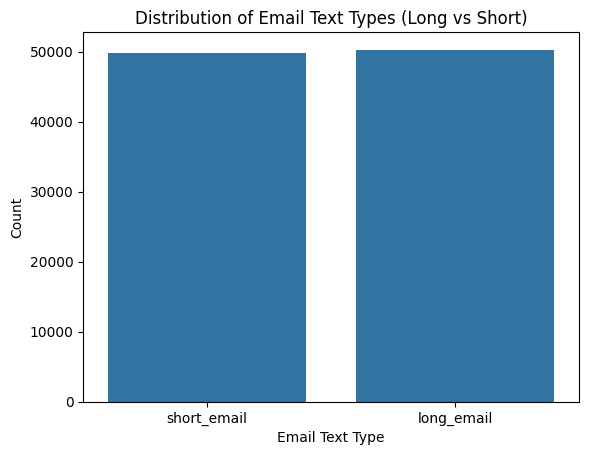

In [27]:
# Countplot of long vs short email text versions
sns.countplot(x='email_text', data=email_df)
plt.title('Distribution of Email Text Types (Long vs Short)')
plt.xlabel('Email Text Type')
plt.ylabel('Count')
plt.show()


# **Step 6: Visualize the Distribution of Personalization**

Explanation: This helps determine how many users got personalized vs generic greetings, which could influence open/click behavior.

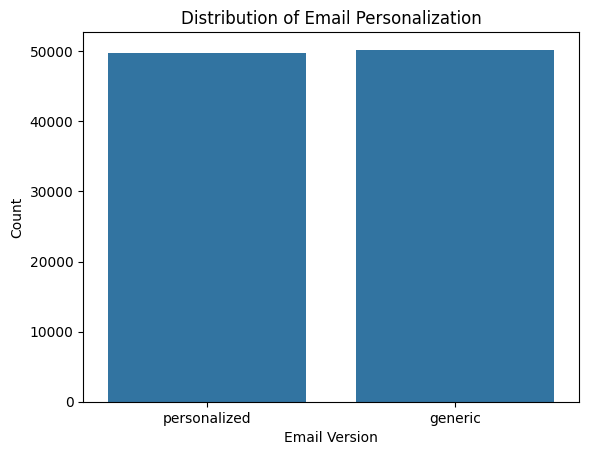

In [11]:
# Countplot of personalized vs generic emails
sns.countplot(x='email_version', data=email_df)
plt.title('Distribution of Email Personalization')
plt.xlabel('Email Version')
plt.ylabel('Count')
plt.show()


# **Step 7: Analyze Email Send Time (Hour and Weekday)**

Explanation: These charts show when emails were sent by hour and day, helping determine if timing affects engagement.

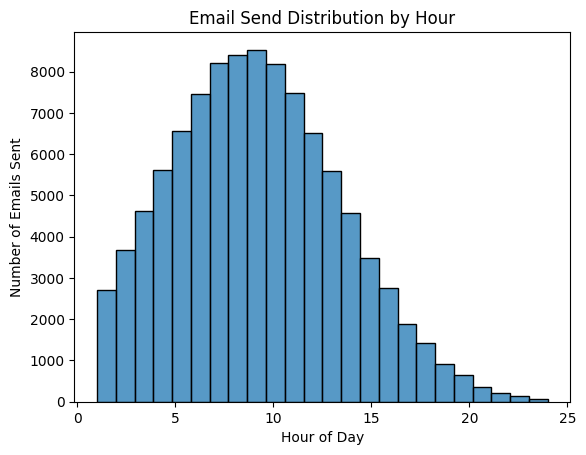

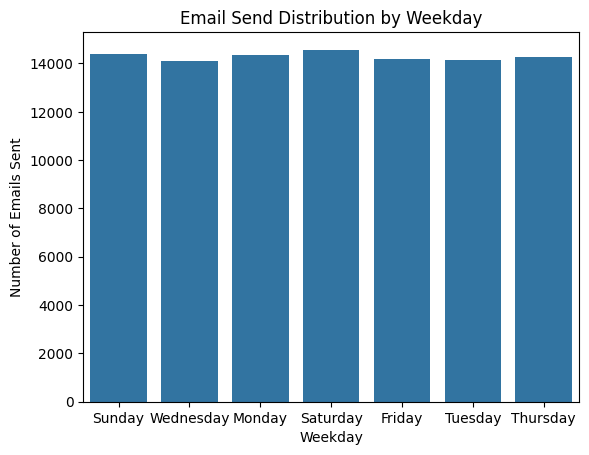

In [12]:
# Distribution of send hour
sns.histplot(email_df['hour'], bins=24, kde=False)
plt.title('Email Send Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Emails Sent')
plt.show()

# Distribution by weekday
sns.countplot(x='weekday', data=email_df)
plt.title('Email Send Distribution by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Emails Sent')
plt.show()


# **Step 8: Distribution of User Past Purchases**

Explanation: Shows whether heavy buyers engage more with the campaign. Log scale helps in viewing skewed data.

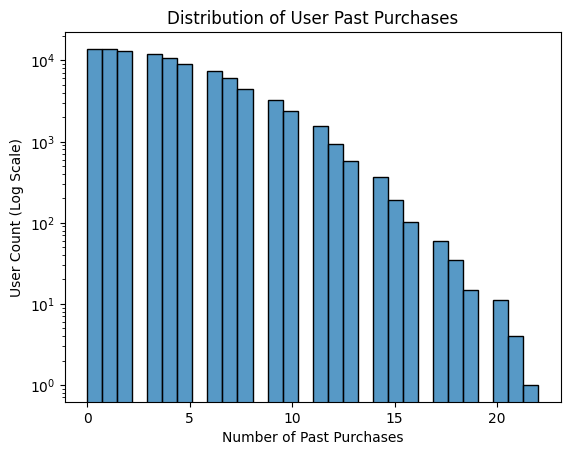

In [13]:
# Histogram of past purchases (log scale to handle skewed data)
sns.histplot(email_df['user_past_purchases'], bins=30)
plt.yscale('log')
plt.title('Distribution of User Past Purchases')
plt.xlabel('Number of Past Purchases')
plt.ylabel('User Count (Log Scale)')
plt.show()


# **Step 9: Open vs Click Rate Comparison**

Explanation: Quickly compares what percentage of users opened vs clicked the email. A large gap may suggest content improvements are needed.

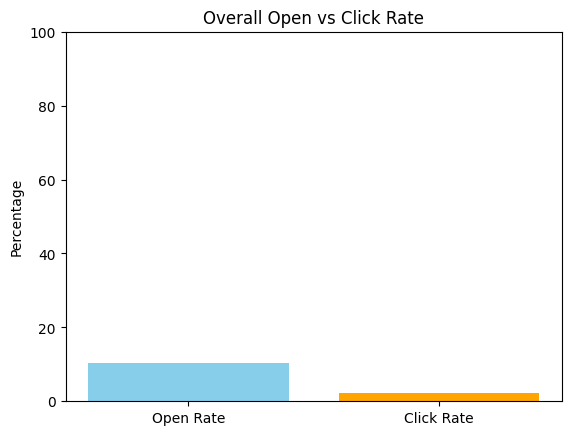

In [14]:
# Bar chart to compare open and click rate
plt.bar(['Open Rate', 'Click Rate'], [open_rate, click_rate], color=['skyblue', 'orange'])
plt.title('Overall Open vs Click Rate')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()


# **Step 10: Funnel Visualization - Email Sent → Opened → Clicked**

Explanation: This shows how users drop off from receiving the email to clicking the link, helping to analyze where engagement is lost.



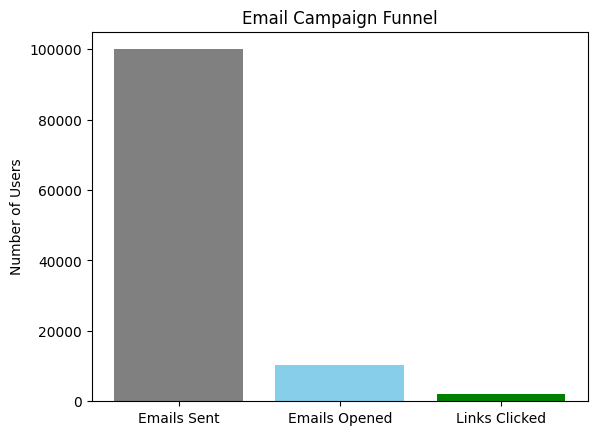

In [15]:
# Calculate funnel values
sent = len(email_df)
opened = email_df['opened'].sum()
clicked = email_df['clicked'].sum()

# Plot the funnel
plt.bar(['Emails Sent', 'Emails Opened', 'Links Clicked'], [sent, opened, clicked], color=['grey', 'skyblue', 'green'])
plt.title('Email Campaign Funnel')
plt.ylabel('Number of Users')
plt.show()


### **Question 2:The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?**

# **Step 1: Import Libraries and Prepare Data**

In [18]:
# Import ML-related libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Copy the DataFrame to avoid changes to original
df = email_df.copy()

# Drop unnecessary column
df.drop('email_id', axis=1, inplace=True)

# Convert categorical variables to numeric using OneHotEncoding
categorical_cols = ['email_text', 'email_version', 'weekday', 'user_country']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('clicked', axis=1)
y = df_encoded['clicked']


# **Step 2: Train-Test Split**

In [19]:
# Split data into training and testing set (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# **Step 3: Train a Classification Model**

In [20]:
# Use Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# **Step 4: Evaluate the Model**

Accuracy Score: 0.97275

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     19576
           1       0.26      0.15      0.19       424

    accuracy                           0.97     20000
   macro avg       0.62      0.57      0.59     20000
weighted avg       0.97      0.97      0.97     20000



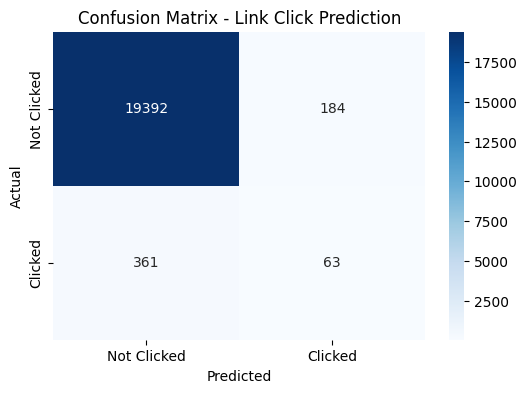

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Print accuracy and classification metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Clicked', 'Clicked'],
            yticklabels=['Not Clicked', 'Clicked'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Link Click Prediction')
plt.show()


# **Step 5: Feature Importance (Optional but Insightful)**

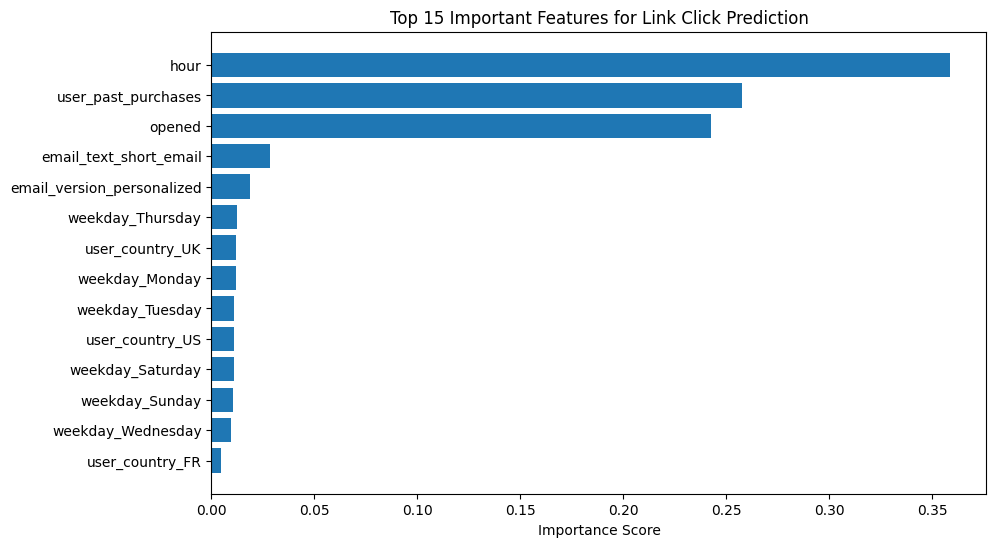

In [22]:
# Plot feature importances to understand key drivers of clicks
importances = clf.feature_importances_
features = X.columns
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Top 15 Important Features for Link Click Prediction')
plt.xlabel('Importance Score')
plt.show()


## **Question 3: Estimating CTR Improvement and How to Test It**

## Part 1: Estimate the Improvement in CTR[link text](https://)

# **Part 1: Estimate the Improvement in CTR**

In [24]:
baseline_ctr = email_df['clicked'].mean()
print(f"Baseline CTR (random targeting): {baseline_ctr:.4f}")


Baseline CTR (random targeting): 0.0212


# **Model-Based CTR (Optimized Strategy)**

In [25]:
# Get predicted probabilities for the positive class (clicked)
y_probs = clf.predict_proba(X_test)[:, 1]

# Create a DataFrame to store probabilities and actual click outcomes
test_df = pd.DataFrame({
    'predicted_prob': y_probs,
    'actual_clicked': y_test.values
})

# Sort users by predicted probability
test_df_sorted = test_df.sort_values(by='predicted_prob', ascending=False)

# Select top 20% most likely users to click
top_20_percent = test_df_sorted.head(int(0.20 * len(test_df_sorted)))

# Calculate click-through rate for this targeted group
model_ctr = top_20_percent['actual_clicked'].mean()

print(f"Model-based CTR (top 20% targeted): {model_ctr:.4f}")
print(f"Improvement over baseline: {model_ctr - baseline_ctr:.4f}")


Model-based CTR (top 20% targeted): 0.0980
Improvement over baseline: 0.0768


# **Code: A/B Simulation + Z-Test**

In [26]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Get predicted probabilities on test data
y_probs = clf.predict_proba(X_test)[:, 1]

# Create a DataFrame with predictions and actual values
ab_df = pd.DataFrame({
    'prob': y_probs,
    'actual': y_test.values
})

# Simulate Group A (Control): Randomly sample 20% of users
group_a = ab_df.sample(frac=0.2, random_state=42)

# Simulate Group B (Treatment): Top 20% based on model prediction
group_b = ab_df.sort_values(by='prob', ascending=False).head(int(0.2 * len(ab_df)))

# CTRs
ctr_a = group_a['actual'].mean()
ctr_b = group_b['actual'].mean()

print(f"CTR (Control Group - Random): {ctr_a:.4f}")
print(f"CTR (Treatment Group - Model-Based): {ctr_b:.4f}")
print(f"Absolute Improvement: {ctr_b - ctr_a:.4f}")

# Z-test: comparing two proportions
clicks = np.array([group_b['actual'].sum(), group_a['actual'].sum()])
n = np.array([len(group_b), len(group_a)])

z_stat, p_value = proportions_ztest(count=clicks, nobs=n)

print(f"\nZ-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")


CTR (Control Group - Random): 0.0203
CTR (Treatment Group - Model-Based): 0.0980
Absolute Improvement: 0.0777

Z-statistic: 14.7423
P-value: 0.0000


 How to Interpret the Results:

CTR (Control) = random targeting performance

CTR (Treatment) = model-based targeting performance

Z-statistic: Measures how many standard deviations the observed difference is from the null hypothesis (no difference)

P-value: If it's < 0.05, the result is statistically significant — meaning your model is likely improving CTR in a meaningful way



# **Question 4:Interesting Patterns in Email Campaign Performance Across Different User Segments**

# **1. Segment by Email Version (Personalized vs. Generic)**


In [28]:
# Group by email version and calculate click-through rates
email_version_ctr = email_df.groupby('email_version')['clicked'].mean()

print("CTR by Email Version:")
print(email_version_ctr)


CTR by Email Version:
email_version
generic         0.015137
personalized    0.027294
Name: clicked, dtype: float64


# **2. Segment by Time of Sending (Hour)**

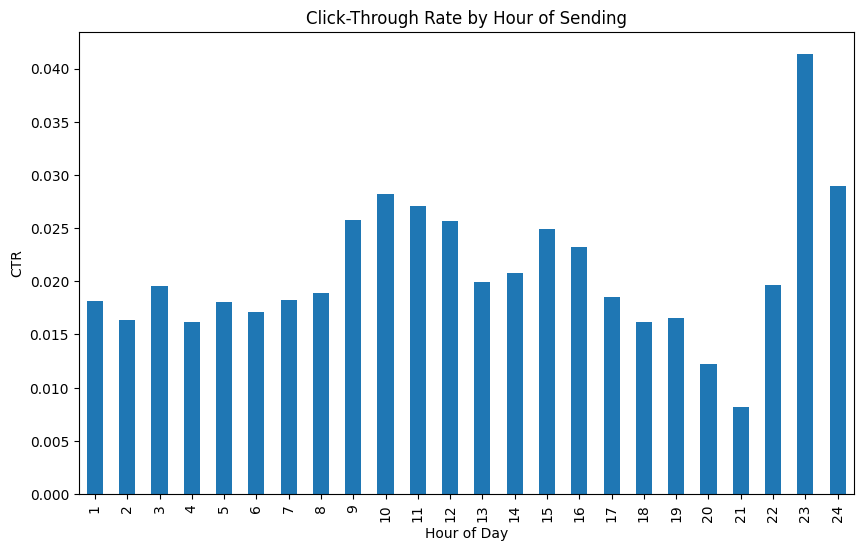

In [29]:
# Group by hour of sending and calculate CTR
time_of_day_ctr = email_df.groupby('hour')['clicked'].mean()

# Plot the result
plt.figure(figsize=(10, 6))
time_of_day_ctr.plot(kind='bar')
plt.title('Click-Through Rate by Hour of Sending')
plt.xlabel('Hour of Day')
plt.ylabel('CTR')
plt.show()


# **3. Segment by Weekday**

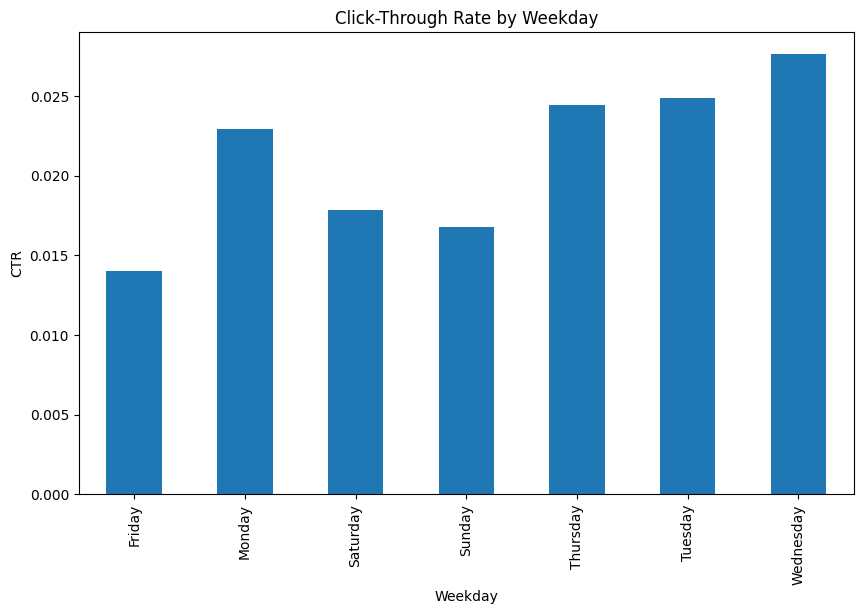

In [30]:
# Group by weekday and calculate CTR
weekday_ctr = email_df.groupby('weekday')['clicked'].mean()

# Plot the result
plt.figure(figsize=(10, 6))
weekday_ctr.plot(kind='bar')
plt.title('Click-Through Rate by Weekday')
plt.xlabel('Weekday')
plt.ylabel('CTR')
plt.show()


# **4. Segment by User’s Past Purchases**

<ipython-input-31-e0b2e867ca96>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_ctr = email_df.groupby('purchase_bin')['clicked'].mean()


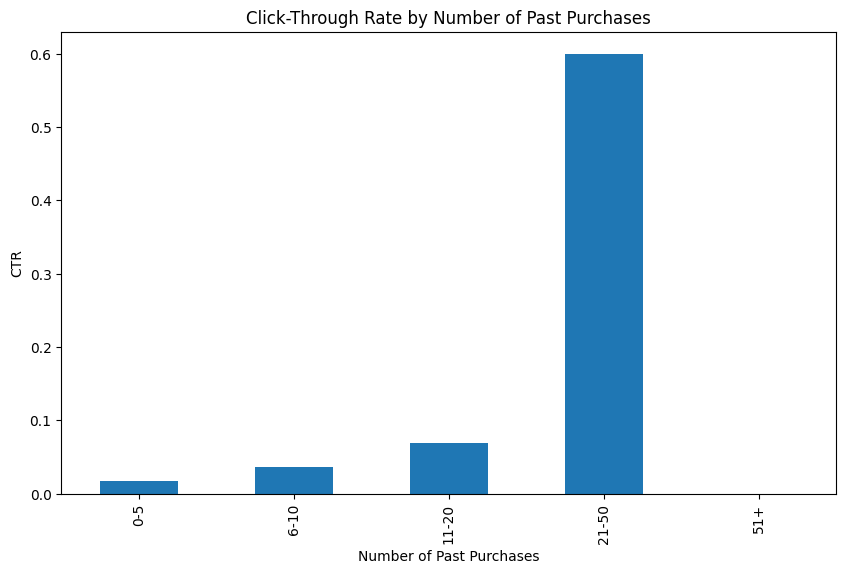

In [31]:
# Create bins for past purchases to categorize users
bins = [0, 5, 10, 20, 50, 100]
labels = ['0-5', '6-10', '11-20', '21-50', '51+']
email_df['purchase_bin'] = pd.cut(email_df['user_past_purchases'], bins=bins, labels=labels)

# Group by purchase bin and calculate CTR
purchase_ctr = email_df.groupby('purchase_bin')['clicked'].mean()

# Plot the result
plt.figure(figsize=(10, 6))
purchase_ctr.plot(kind='bar')
plt.title('Click-Through Rate by Number of Past Purchases')
plt.xlabel('Number of Past Purchases')
plt.ylabel('CTR')
plt.show()


# **5. Segment by User’s Country**

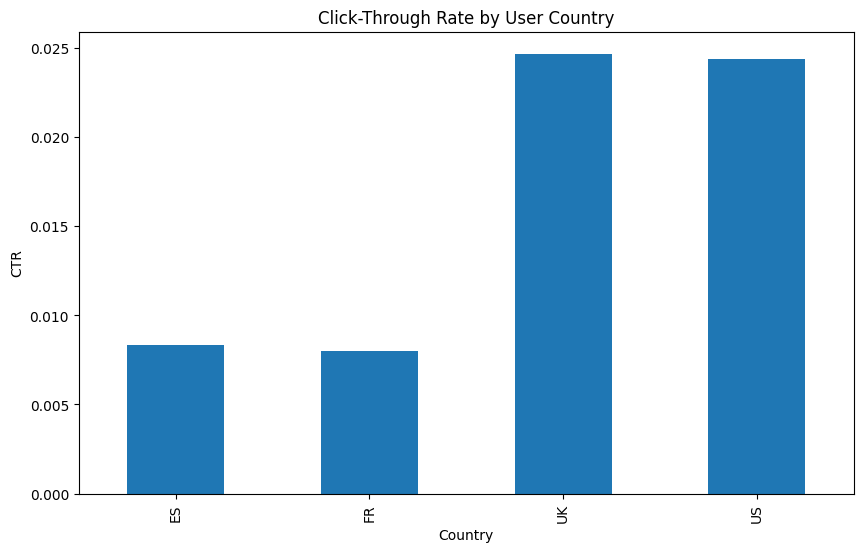

In [32]:
# Group by user country and calculate CTR
country_ctr = email_df.groupby('user_country')['clicked'].mean()

# Plot the result
plt.figure(figsize=(10, 6))
country_ctr.plot(kind='bar')
plt.title('Click-Through Rate by User Country')
plt.xlabel('Country')
plt.ylabel('CTR')
plt.show()
